<div align="center">
    <h1>Implementation of the DQN (Deep Q-Network) Algorithm</h1>
</div>

We will start by implementing the **[DQN](https://medium.com/@samina.amin/deep-q-learning-dqn-71c109586bae)** algorithm, which will be used to train our model. This algorithm requires the use of a **neural network**, for which we will use the **[PyTorch](https://pytorch.org/)** package.

<!-- <div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:2400/format:webp/1*aqNgmfyBIStLrf9k7d9cng.jpeg" width="500px">
</div> -->

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Pytorch connected to {device}')

Pytorch connected to cpu


In [2]:
import gymnasium as gym

env = gym.make('CartPole-v1')

In [3]:
import random
import torch

seed = 42
random.seed(seed)
torch.manual_seed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

### Building the Neural Network
Let’s start with building the **neural network**. The **architecture** of the network will be as follows:
1. **Input Layer** with **4 nodes** (number of observations)
2. **Hidden Layer 1** with **128 nodes**
3. **Hidden Layer 2** with **128 nodes**
4. **Output Layer** with **2 nodes** (number of actions)

In [4]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F


class DeepQNetwork_CartPole(nn.Module):
    def __init__(self, input_dims: int, output_dims: int) -> None:
        super(DeepQNetwork_CartPole, self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims

        self.fc1 = nn.Linear(self.input_dims, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, self.output_dims)
          

    def forward(self, state: T.Tensor) -> T.Tensor:
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


In [5]:
import numpy as np
from collections import deque
import torch as T


class ReplayBufferMemory:
    def __init__(self, capacity=10000, device='cpu'):
        self.device = device
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = np.random.choice(len(self.memory), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.memory[i] for i in batch])
        return (
            T.Tensor(np.array(states)).to(self.device),
            T.LongTensor(np.array(actions)).to(self.device),
            T.Tensor(np.array(rewards)).to(self.device),
            T.Tensor(np.array(next_states)).to(self.device),
            T.Tensor(np.array(dones)).to(self.device)
        )
    
    def __len__(self):
        return len(self.memory)


In [6]:
import torch as T
import torch.nn as nn
import numpy as np


class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, n_actions, device):
        self.gamma = gamma

        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        self.input_dims = input_dims
        self.n_actions = n_actions
        self.device = device

        self.action_space = [i for i in range(n_actions)]
        self.batch_size = 64
        self.target_update_freq = 10
        self.memory_size = 10000

        # Initialize the Deep Q-Networks and send to device
        self.policy_network = DeepQNetwork_CartPole(input_dims, n_actions).to(self.device)
        self.target_network = DeepQNetwork_CartPole(input_dims, n_actions).to(self.device)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.target_network.eval()

        self.learning_rate = lr
        self.optimizer = T.optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)
        self.memory_buffer = ReplayBufferMemory(capacity=self.memory_size, device=self.device)

        self.steps_done = 0  # Track total steps globally

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            state = T.tensor(np.array([observation]), dtype=T.float32).to(self.device)
            with T.no_grad():
                actions = self.policy_network(state)
            best_action = T.argmax(actions).item()
            return best_action

    def optimize(self):
        if len(self.memory_buffer) < self.batch_size:
            return

        # Sample batch from replay buffer - assume tensors on device already
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory_buffer.sample(self.batch_size)

        # Compute current Q values
        q_values = self.policy_network(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)

        # Compute target Q values using target network
        with T.no_grad():
            max_next_q_values = self.target_network(next_state_batch).max(1)[0]
            target_q_values = reward_batch + self.gamma * max_next_q_values * (1 - done_batch)

        # Calculate loss
        loss = nn.MSELoss()(q_values, target_q_values)

        # Optimize model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


In [7]:
class Trainer():
    def __init__(self, agent, env):
        self.agent = agent
        self.env = env

    def train_agent(self, num_episodes=100, seed=42):
        score_per_episode = []
        loss_per_episode = []
        epsilon_per_episode = []

        for episode in range(num_episodes):
            observation, info = self.env.reset(seed=seed)
            episode_score, episode_loss = 0, 0
            done = False

            while not done:
                action = self.agent.choose_action(observation)
                next_observation, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated

                self.agent.memory_buffer.add(observation, action, reward, next_observation, float(done))

                observation = next_observation
                episode_score += reward

                loss = self.agent.optimize()
                if loss is not None:
                    episode_loss += loss

                self.agent.steps_done += 1
                if self.agent.steps_done % self.agent.target_update_freq == 0:
                    self.agent.target_network.load_state_dict(self.agent.policy_network.state_dict())

            epsilon_per_episode.append(self.agent.epsilon)
            score_per_episode.append(episode_score)
            loss_per_episode.append(episode_loss)

            self.agent.decay_epsilon()

            # Logging progress every ~10% of total episodes
            if episode == 0 or episode == num_episodes - 1 or episode % max(1, num_episodes // 10) == 0:
                if episode == 0 or episode == num_episodes - 1: print(f'Episode {episode+1}:', end=' ')
                else: print(f'Episode {episode}: ', end=' ')
                print(f"Score: {episode_score}, Epsilon: {self.agent.epsilon:.2f}")

        return {
            "scores": score_per_episode, 
            "losses": loss_per_episode, 
            "epsilons": epsilon_per_episode
        }


In [8]:
agent = Agent(0.99, 1.0, 0.001, 4, 2, device)
trainer = Trainer(agent, env)

results = trainer.train_agent(200)

env.close()

Episode 1: Score: 33.0, Epsilon: 0.99
Episode 20:  Score: 25.0, Epsilon: 0.90
Episode 40:  Score: 86.0, Epsilon: 0.81
Episode 60:  Score: 44.0, Epsilon: 0.74
Episode 80:  Score: 17.0, Epsilon: 0.67
Episode 100:  Score: 42.0, Epsilon: 0.60
Episode 120:  Score: 224.0, Epsilon: 0.55
Episode 140:  Score: 199.0, Epsilon: 0.49
Episode 160:  Score: 133.0, Epsilon: 0.45
Episode 180:  Score: 288.0, Epsilon: 0.40
Episode 200: Score: 108.0, Epsilon: 0.37


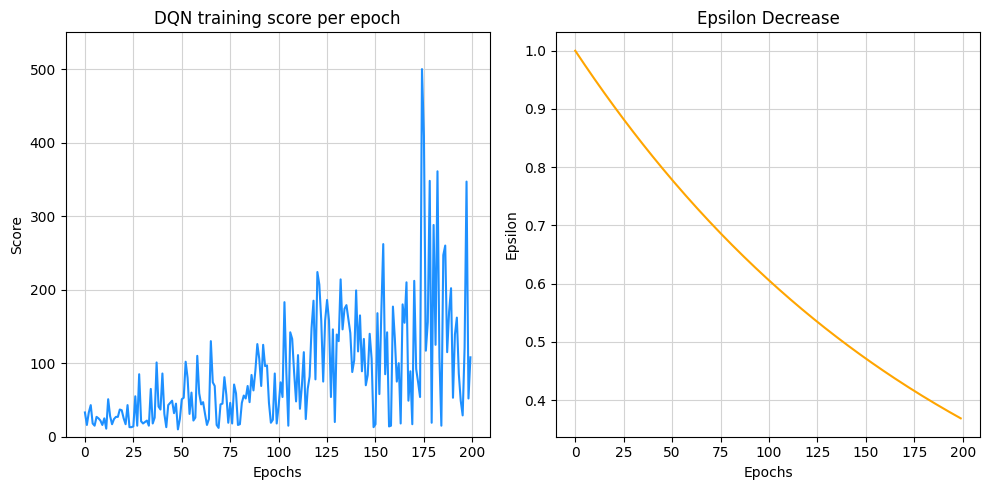

In [9]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].plot(results['scores'], color='dodgerblue')
axis[0].set_ylim(0, 550)
axis[0].set_title("DQN training score per epoch")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Score")
axis[0].grid(color='lightgrey')

axis[1].plot(results['epsilons'], color='orange')
axis[1].set_title("Epsilon Decrease")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Epsilon")
axis[1].grid(color='lightgrey')

plt.tight_layout()
plt.show()